In [33]:
from tqdm import tqdm

import glob
import ntpath
import cv2

from sklearn.metrics.pairwise import cosine_similarity
import scipy as sc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import io
import bson
import matplotlib.pyplot as plt
from skimage.io import imread   # or, whatever image library you prefer
import multiprocessing as mp      # will come in handy due to the size of the data
from PIL import Image

In [100]:
import glob
image_paths = glob.glob('/home/shreya/test/*.jpg')

In [101]:
images = {}
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # Splitting the RGB Channels of the image
    image = cv2.merge([r,g,b]) 
    image = cv2.resize(image, (200, 200))
    #images[ntpath.basename(image_path)] = image
    images[image_path] = image
    

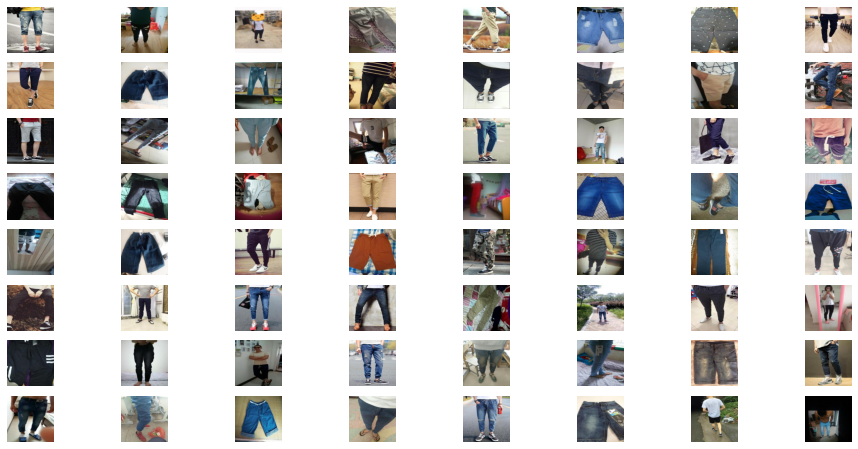

In [102]:
n_col = 8
n_row = 8
f, ax = plt.subplots(n_row, n_col, figsize=(16, 8))
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(list(images.values())[n_col*i + j])
        ax[i, j].set_axis_off()

In [103]:
def load_image(image):
    image = plt.imread(image)
    img = tf.image.convert_image_dtype(image, tf.float32)
    img = tf.image.resize(img, [400, 400])
    img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d)
    return img

# content layers describe the image subject
content_layers = ['block5_conv2'] 

# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 

def selected_layers_model(layer_names, baseline_model):
    outputs = [baseline_model.get_layer(name).output for name in layer_names]
    model = Model([vgg.input], outputs)
    return model

# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

class StyleModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleModel, self).__init__()
        self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        # scale back the pixel values
        inputs = inputs*255.0
        # preprocess them with respect to VGG19 stats
        preprocessed_input = preprocess_input(inputs)
        # pass through the reduced network
        outputs = self.vgg(preprocessed_input)
        # segregate the style and content representations
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # calculate the gram matrix for each layer
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        # assign the content representation and gram matrix in
        # a layer by layer fashion in dicts
        content_dict = {content_name:value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()]) 
    
# compute styles
image_style_embeddings = {}
for image_path in tqdm(image_paths):
    image_tensor = load_image(image_path)
    style = style_to_vec(image_to_style(image_tensor))
    image_style_embeddings[image_path] = style

100%|██████████| 1500/1500 [12:06<00:00,  2.06it/s]


In [104]:
def search_by_style_display(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i, img in enumerate(sorted_neighbors[:max_results]):
        ax[i].imshow(images[img[0]])
        ax[i].set_axis_off()
    
    plt.show()


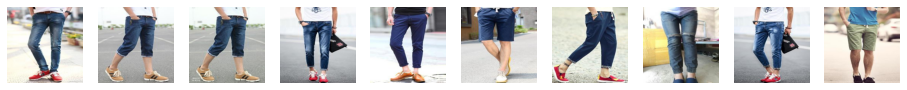

In [105]:
search_by_style_display('/home/shreya/test/18.jpg')

In [106]:
def search_by_style(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    return sorted_neighbors[:11]

In [108]:
x = []
for image_name in tqdm(images.keys()):
    z = search_by_style(image_name)
    x.append(z)
    #print(len(x))
    #if len(x) == 1500:
     #   break

100%|██████████| 1500/1500 [05:04<00:00,  4.93it/s]


In [109]:
search_by_style('/home/shreya/test/5.jpg')

[('/home/shreya/test/5.jpg', 0),
 ('/home/shreya/test/1204.jpg', 0.0415000319480896),
 ('/home/shreya/test/1320.jpg', 0.04603296518325806),
 ('/home/shreya/test/1108.jpg', 0.04796868562698364),
 ('/home/shreya/test/15.jpg', 0.04818922281265259),
 ('/home/shreya/test/830.jpg', 0.0483471155166626),
 ('/home/shreya/test/318.jpg', 0.04922902584075928),
 ('/home/shreya/test/324.jpg', 0.05011540651321411),
 ('/home/shreya/test/1079.jpg', 0.05016893148422241),
 ('/home/shreya/test/1211.jpg', 0.05026882886886597),
 ('/home/shreya/test/1385.jpg', 0.051384150981903076)]

In [110]:
y = pd.DataFrame(x)
y

,0,1,2,3,4,5,6,7,8,9,10
0,"(/home/shreya/test/456.jpg, 0)","(/home/shreya/test/274.jpg, 0.018698811531066895)","(/home/shreya/test/1495.jpg, 0.019262194633483...","(/home/shreya/test/703.jpg, 0.019513189792633057)","(/home/shreya/test/450.jpg, 0.01954275369644165)","(/home/shreya/test/518.jpg, 0.0224151611328125)","(/home/shreya/test/126.jpg, 0.023084938526153564)","(/home/shreya/test/718.jpg, 0.023639261722564697)","(/home/shreya/test/1138.jpg, 0.02393728494644165)","(/home/shreya/test/152.jpg, 0.024002373218536377)","(/home/shreya/test/1078.jpg, 0.024007797241210..."
1,"(/home/shreya/test/916.jpg, 0)","(/home/shreya/test/1148.jpg, 0.034094154834747...","(/home/shreya/test/351.jpg, 0.03489971160888672)","(/home/shreya/test/1140.jpg, 0.03557729721069336)","(/home/shreya/test/1121.jpg, 0.038192927837371...","(/home/shreya/test/755.jpg, 0.03867745399475098)","(/home/shreya/test/706.jpg, 0.0388302206993103)","(/home/shreya/test/935.jpg, 0.03890419006347656)","(/home/shreya/test/732.jpg, 0.039252281188964844)","(/home/shreya/test/349.jpg, 0.039285242557525635)","(/home/shreya/test/960.jpg, 0.03975105285644531)"
2,"(/home/shreya/test/804.jpg, 0)","(/home/shreya/test/1324.jpg, 0.04702812433242798)","(/home/shreya/test/1259.jpg, 0.04866665601730347)","(/home/shreya/test/1301.jpg, 0.04870009422302246)","(/home/shreya/test/1108.jpg, 0.049538493156433...","(/home/shreya/test/1094.jpg, 0.050561487674713...","(/home/shreya/test/18.jpg, 0.05108672380447388)","(/home/shreya/test/1320.jpg, 0.0528721809387207)","(/home/shreya/test/807.jpg, 0.054817140102386475)","(/home/shreya/test/910.jpg, 0.054833829402923584)","(/home/shreya/test/1177.jpg, 0.05564814805984497)"
3,"(/home/shreya/test/1176.jpg, 0)","(/home/shreya/test/99.jpg, 0.04689067602157593)","(/home/shreya/test/149.jpg, 0.056559205055236816)","(/home/shreya/test/805.jpg, 0.05936551094055176)","(/home/shreya/test/1215.jpg, 0.061942458152770...","(/home/shreya/test/95.jpg, 0.06210184097290039)","(/home/shreya/test/1499.jpg, 0.06260401010513306)","(/home/shreya/test/529.jpg, 0.06355506181716919)","(/home/shreya/test/477.jpg, 0.06689167022705078)","(/home/shreya/test/229.jpg, 0.06768155097961426)","(/home/shreya/test/458.jpg, 0.06842315196990967)"
4,"(/home/shreya/test/1163.jpg, 0)","(/home/shreya/test/1052.jpg, 0.03757798671722412)","(/home/shreya/test/450.jpg, 0.037749648094177246)","(/home/shreya/test/1042.jpg, 0.0384523868560791)","(/home/shreya/test/1048.jpg, 0.038935303688049...","(/home/shreya/test/1146.jpg, 0.03908264636993408)","(/home/shreya/test/680.jpg, 0.039149701595306396)","(/home/shreya/test/126.jpg, 0.04231917858123779)","(/home/shreya/test/1144.jpg, 0.043526291847229...","(/home/shreya/test/1446.jpg, 0.044547080993652...","(/home/shreya/test/500.jpg, 0.044667065143585205)"
...,...,...,...,...,...,...,...,...,...,...,...
1495,"(/home/shreya/test/1425.jpg, 0)","(/home/shreya/test/1418.jpg, 0.03513568639755249)","(/home/shreya/test/1417.jpg, 0.03560370206832886)","(/home/shreya/test/463.jpg, 0.0503087043762207)","(/home/shreya/test/846.jpg, 0.056560397148132324)","(/home/shreya/test/833.jpg, 0.05878901481628418)","(/home/shreya/test/853.jpg, 0.06441181898117065)","(/home/shreya/test/1261.jpg, 0.06451517343521118)","(/home/shreya/test/1040.jpg, 0.06511706113815308)","(/home/shreya/test/74.jpg, 0.06708800792694092)","(/home/shreya/test/83.jpg, 0.06825762987136841)"
1496,"(/home/shreya/test/873.jpg, 0)","(/home/shreya/test/1320.jpg, 0.02164173126220703)","(/home/shreya/test/1452.jpg, 0.024947524070739...","(/home/shreya/test/365.jpg, 0.02547067403793335)","(/home/shreya/test/1177.jpg, 0.028613030910491...","(/home/shreya/test/1049.jpg, 0.028634250164031...","(/home/shreya/test/1138.jpg, 0.029533088207244...","(/home/shreya/test/1108.jpg, 0.03031104803085327)","(/home/shreya/test/464.jpg, 0.030712664127349854)","(/home/shreya/test/777.jpg, 0.03150355815887451)","(/home/shreya/test/1410.jpg, 0.032301366329193..."
1497,"(/home/shreya/test/1498.jpg, 0)","(/home/shreya/test/930.jpg,

In [111]:
def test(neigh):
    return neigh[0]

In [112]:
z = y.applymap(test)

In [113]:
z

,0,1,2,3,4,5,6,7,8,9,10
0,/home/shreya/test/456.jpg,/home/shreya/test/274.jpg,/home/shreya/test/1495.jpg,/home/shreya/test/703.jpg,/home/shreya/test/450.jpg,/home/shreya/test/518.jpg,/home/shreya/test/126.jpg,/home/shreya/test/718.jpg,/home/shreya/test/1138.jpg,/home/shreya/test/152.jpg,/home/shreya/test/1078.jpg
1,/home/shreya/test/916.jpg,/home/shreya/test/1148.jpg,/home/shreya/test/351.jpg,/home/shreya/test/1140.jpg,/home/shreya/test/1121.jpg,/home/shreya/test/755.jpg,/home/shreya/test/706.jpg,/home/shreya/test/935.jpg,/home/shreya/test/732.jpg,/home/shreya/test/349.jpg,/home/shreya/test/960.jpg
2,/home/shreya/test/804.jpg,/home/shreya/test/1324.jpg,/home/shreya/test/1259.jpg,/home/shreya/test/1301.jpg,/home/shreya/test/1108.jpg,/home/shreya/test/1094.jpg,/home/shreya/test/18.jpg,/home/shreya/test/1320.jpg,/home/shreya/test/807.jpg,/home/shreya/test/910.jpg,/home/shreya/test/1177.jpg
3,/home/shreya/test/1176.jpg,/home/shreya/test/99.jpg,/home/shreya/test/149.jpg,/home/shreya/test/805.jpg,/home/shreya/test/1215.jpg,/home/shreya/test/95.jpg,/home/shreya/test/1499.jpg,/home/shreya/test/529.jpg,/home/shreya/test/477.jpg,/home/shreya/test/229.jpg,/home/shreya/test/458.jpg
4,/home/shreya/test/1163.jpg,/home/shreya/test/1052.jpg,/home/shreya/test/450.jpg,/home/shreya/test/1042.jpg,/home/shreya/test/1048.jpg,/home/shreya/test/1146.jpg,/home/shreya/test/680.jpg,/home/shreya/test/126.jpg,/home/shreya/test/1144.jpg,/home/shreya/test/1446.jpg,/home/shreya/test/500.jpg
...,...,...,...,...,...,...,...,...,...,...,...
1495,/home/shreya/test/1425.jpg,/home/shreya/test/1418.jpg,/home/shreya/test/1417.jpg,/home/shreya/test/463.jpg,/home/shreya/test/846.jpg,/home/shreya/test/833.jpg,/home/shreya/test/853.jpg,/home/shreya/test/1261.jpg,/home/shreya/test/1040.jpg,/home/shreya/test/74.jpg,/home/shreya/test/83.jpg
1496,/home/shreya/test/873.jpg,/home/shreya/test/1320.jpg,/home/shreya/test/1452.jpg,/home/shreya/test/365.jpg,/home/shreya/test/1177.jpg,/home/shreya/test/1049.jpg,/home/shreya/test/1138.jpg,/home/shreya/test/1108.jpg,/home/shreya/test/464.jpg,/home/shreya/test/777.jpg,/home/shreya/test/1410.jpg
1497,/home/shreya/test/1498.jpg,/home/shreya/test/930.jpg,/home/shreya/test/59.jpg,/home/shreya/test/1153.jpg,/home/shreya/test/166.jpg,/home/shreya/test/350.jpg,/home/shreya/test/1027.jpg,/home/shreya/test/83.jpg,/home/shreya/test/900.jpg,/home/shreya/test/1123.jpg,/home/shreya/test/821.jpg
1498,/home/shreya/test/862.jpg,/home/shreya/test/857.jpg,/home/shreya/test/975.jpg,/home/shreya/test/413.jpg,/home/shreya/test/1096.jpg,/home/shreya/test/1084.jpg,/home/shreya/test/1414.jpg,/home/shreya/test/1213.jpg,/home/shreya/test/1188.jpg,/home/shreya/test/1087.jpg,/home/shreya/test/1156.jpg


In [114]:
z.to_csv('Artistic.csv')